In [1]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import torch
import loss
import tqdm

import cv2

plt.rc('figure', figsize=(15, 15))

In [2]:
p = pathlib.Path(f'data/data_1000.npz')
res = np.load(p)

times = res['times']
x = res['x']
x_osgb = res['x_osgb']
y = res['y']
y_osgb = res['y_osgb']
data = res['data']

In [3]:
# we should probably set this better
# exploratory analysis shows this might be a good time range
# the analysi was done looking at winter 
# we could tighten this to better guarentee always getting a good pic
start_hour = 9
end_hour = 15


In [4]:
times[0]

numpy.datetime64('2020-01-01T00:05:00.000000000')

In [5]:
def extract_hour(dt: np.datetime64):
    return (dt.astype('M8[h]') - dt.astype('M8[D]')).astype(int)


In [6]:
# get ok times
times_mask = []
for i in range(len(times)):
    if start_hour <= extract_hour(times[i]) <= end_hour:
        times_mask.append(i)

In [7]:
# grab the data in the right time range
times = times[times_mask]
data = data[times_mask]

In [8]:
MIN = 0
MAX = 1023

# we need to normalize in this range to use optical flow
data -= MIN
data = data / (MAX - MIN)
data *= 255
data = data.astype(np.uint8)

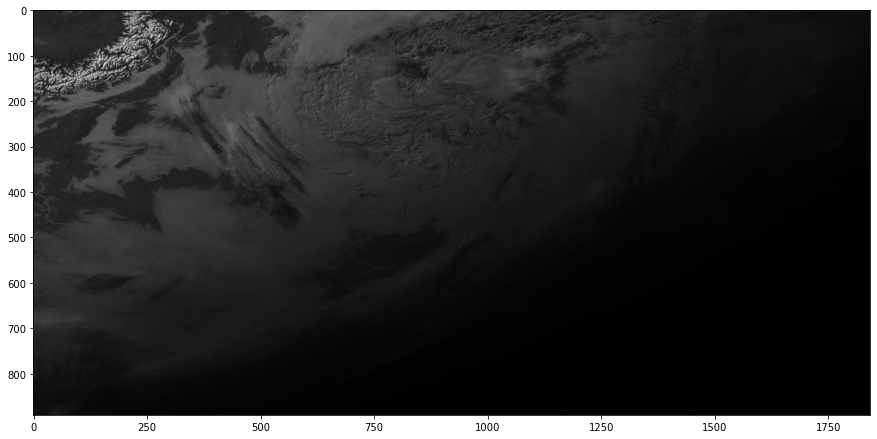

In [9]:
plt.imshow(data[0], cmap='gray')

In [10]:
len(times)

281

In [11]:
times[100], times[101]

(numpy.datetime64('2020-01-02T10:20:00.000000000'),
 numpy.datetime64('2020-01-02T10:25:00.000000000'))

In [12]:
flows_default = cv2.calcOpticalFlowFarneback(
    prev=data[100],
    next=data[101],
    flow=None,
    pyr_scale=0.5, levels=3, winsize=15, 
    iterations=10, poly_n=5, poly_sigma=1.2, 
    flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

In [13]:
flows_default.shape

(891, 1843, 2)

In [14]:
np.unravel_index(np.argmax(flows_default), flows_default.shape)

(6, 1809, 1)

In [15]:
flows_default[278, 212]

array([-0.99153143,  2.6080334 ], dtype=float32)

In [16]:
# example, without interpolation. we rounded 1.68 -> 2, -0.69 -> -1
pred = data[101][278 + 2, 212 - 1]
original = data[101][278, 212]
actual = data[100][278, 212]

print(pred, original, actual)

48 33 46


In [29]:
def get_crop_idxs():
    rand_x = np.random.randint(550, 950 - 128)
    rand_y = np.random.randint(375, 700 - 128)
    
    yslice = slice(rand_y, rand_y + 128)
    xslice = slice(rand_x, rand_x + 128)
    
    return xslice, yslice
    
    
def get_mssim(y, x):
    mssim_loss = loss.MS_SSIMLoss(channels=1)
    yd = np.expand_dims(np.expand_dims(y, 0), 0)/255 * (MAX - MIN) + MIN
    xd = np.expand_dims(np.expand_dims(x, 0), 0)/255 * (MAX - MIN) + MIN
    return 1.0 - mssim_loss(
        torch.Tensor(yd),
        torch.Tensor(xd),
    )

In [18]:
idx = 250
# make sure these are 120 minutes apart
(times[100+24].astype('M8[m]') - times[100].astype('M8[m]')).astype(int)


120

In [21]:
y.shape, x.shape

((128, 128), (128, 128))

In [26]:
x[32:96,32:96].shape

(64, 64)

In [34]:
np.random.seed(7)

scores = []

for idx in tqdm.notebook.tqdm(range(200)):
    diff = (times[idx+24].astype('M8[m]') - times[idx].astype('M8[m]')).astype(int)
    if diff != 120:
        continue

    _scores = np.zeros((30, 24))
    for i in range(30):
        xslice, yslice = get_crop_idxs()
        x = data[idx, yslice, xslice]
        for j in range(1, 25):
            y = data[idx + j, yslice, xslice]
            # grab middle 64x64 and compare
            score = get_mssim(y[32:32+64,32:32+64], x[32:32+64,32:32+64])
            _scores[i,j - 1] = score
    scores_summary = _scores.mean(axis=0)
    scores.append(scores_summary)
    


  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [43]:
def predict(coordinates: np.ndarray, data: np.ndarray) -> np.ndarray:
    """Makes a prediction for the next two hours of satellite imagery.

    Args:
        coordinates (np.ndarray): the OSGB x and y coordinates (2, 128, 128)
        data (np.ndarray): an array of 12 128*128 satellite images (12, 128, 128)

    Returns:
        np.ndarray: an array of 24 64*64 satellite image predictions (24, 64, 64)
    """

#     assert coordinates.shape == (2, 128, 128)
    assert data.shape == (12, 128, 128)

    prediction = np.expand_dims(data[-1][32:96,32:96], 0)
    prediction = np.tile(prediction, (24, 1, 1))
    assert prediction.shape == (24, 64, 64)
    return prediction


In [47]:
inp = np.tile(np.expand_dims(x, 0), (12, 1, 1))

In [48]:
inp.shape

(12, 128, 128)

In [50]:
out = predict(None, inp)

In [51]:
out.shape

(24, 64, 64)

In [250]:
def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

In [251]:
res = warp_flow(data[100], flows_default)

In [241]:
image_pred = remap_image(data[100], flows_default)

In [253]:
np.abs(data[101] - image_pred).sum()

47577421

In [243]:
np.abs(data[101] - data[100]).sum()

47646307

In [368]:
def get_mssim(y, x):
    mssim_loss = loss.MS_SSIMLoss(channels=1)
    yd = np.expand_dims(np.expand_dims(y, 0), 0)/255 * (MAX - MIN) + MIN
    xd = np.expand_dims(np.expand_dims(x, 0), 0)/255 * (MAX - MIN) + MIN
    return 1.0 - mssim_loss(
        torch.Tensor(yd),
        torch.Tensor(xd),
    )

In [256]:
metrics.structural_similarity(data[101], data[101])

1.0

In [366]:
mssim_loss(
    torch.Tensor(yd),
    torch.Tensor(xd),
)



tensor(0.0191)

In [257]:
metrics.structural_similarity(data[101], data[100])

0.9873687083520152

In [262]:
scores = []
for i in range(1, 24):
    score = metrics.structural_similarity(data[100 + i], data[100])
    scores.append(score)

In [263]:
scores

[0.9873687083520152,
 0.9784388263973011,
 0.9703673668595131,
 0.9619900326719778,
 0.9531044338670835,
 0.9435419464114808,
 0.9337397105081419,
 0.9239707583503768,
 0.9141303631722634,
 0.9046233406986642,
 0.8956186252524311,
 0.8870657566292323,
 0.8788996840287139,
 0.8714285410163158,
 0.8645469906436939,
 0.8582872619067238,
 0.8524233107591549,
 0.8474546913495103,
 0.8427634138227698,
 0.8385913321217616,
 0.8350458496913864,
 0.8321538331735231,
 0.8295697753773819]

In [261]:
metrics.structural_similarity(data[104], data[100])

0.9619900326719778

In [ ]:
cv2.remap()